Пример Unet архитектуры

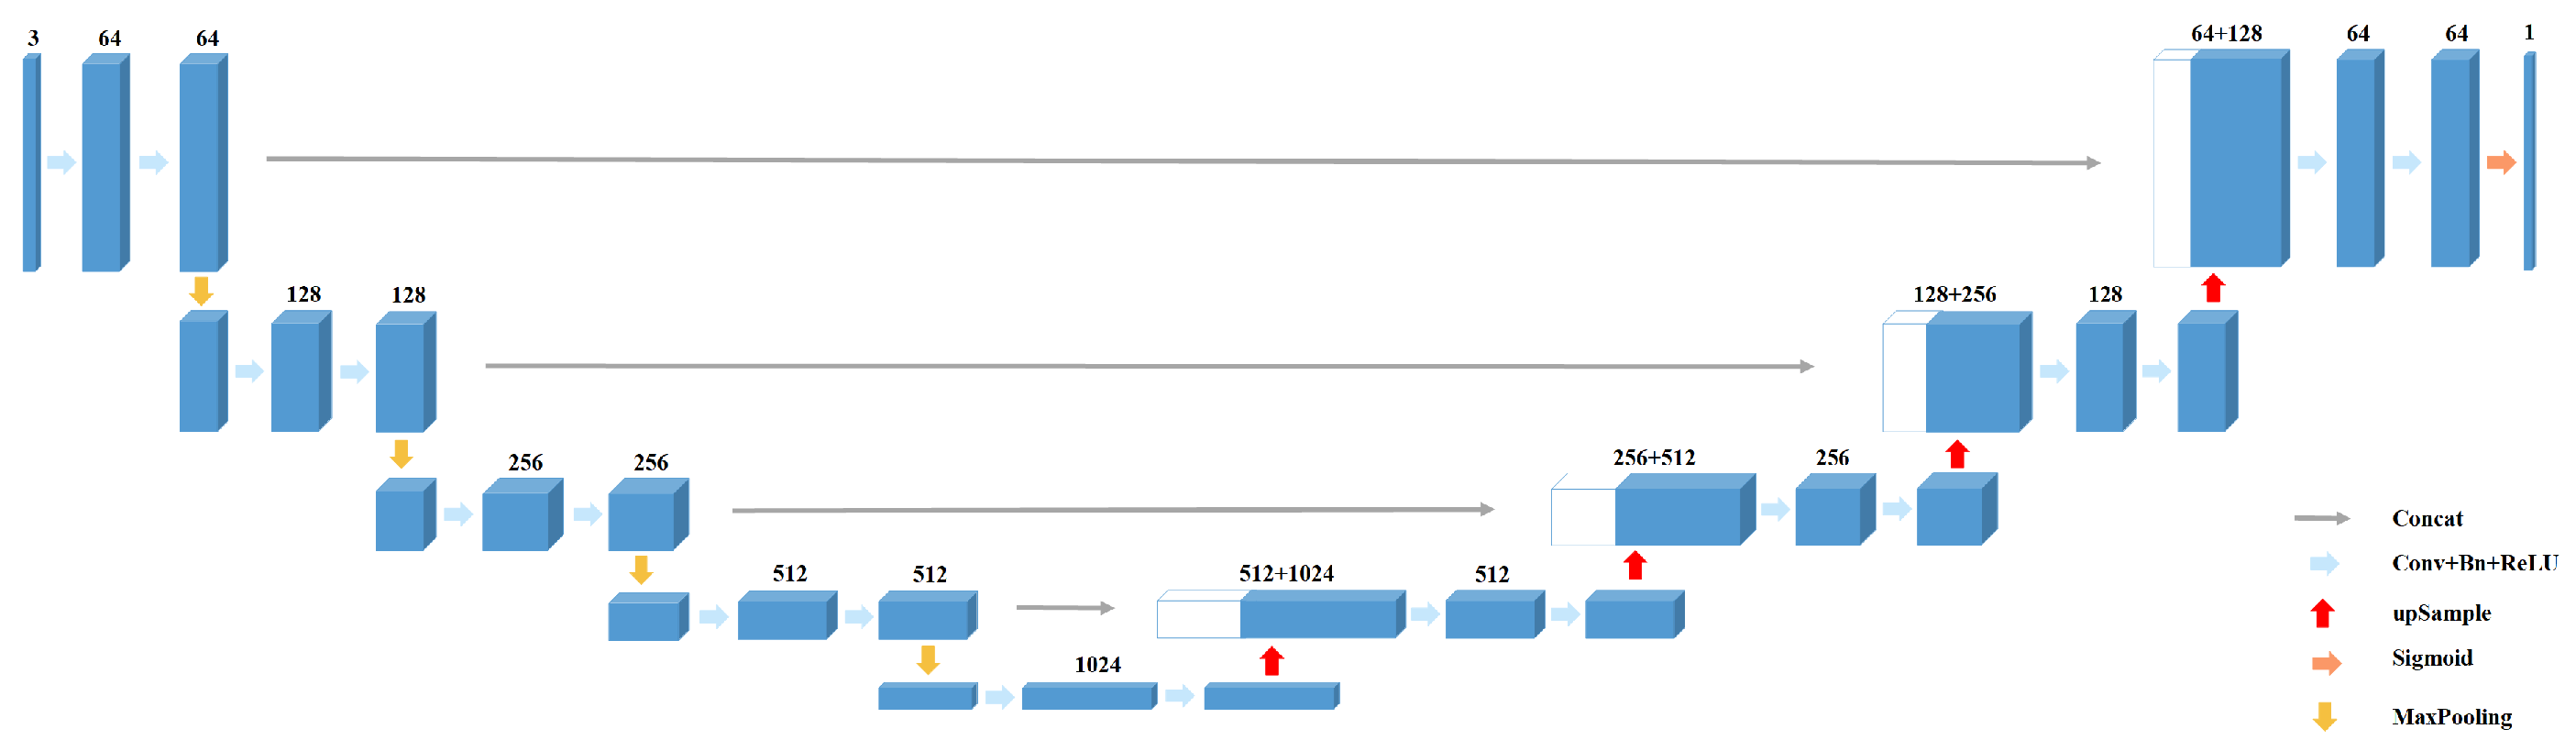

In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A  # для аугментации
from albumentations.pytorch import ToTensorV2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

## Блоки Unet NN

<b>CNA блок</b> - Convolution, Normalization, Activation  
Так же стоит отключать bias перед нормализацией, тк функиция нормализации уже включает в себя параметры смещения и масштаба, которые могут обучаться. Эти параметры выполняют ту же функцию, что и смещение в сверточном слое. Включение смещения в сверточном слое становится избыточным.

<u>bias:</u>  
В линейных слоях (и свертках) формула для вычисления выхода выглядит как y=Wx+b, где W — это весовая матрица, x — входные данные, а b — смещение.  
Зачем нужен bias?
- Смещение уровня активации: Без смещения активация нейрона всегда будет проходить через начало координат (точка (0,0)), что ограничивает пространство решений. Смещение позволяет сдвинуть функцию активации, что помогает сети лучше обучаться.
- Увеличение выразительности модели: Смещение добавляет степени свободы, что позволяет модели лучше приспосабливаться к данным и выражать более сложные зависимости.

Смещение уровня активации: Без смещения активация нейрона всегда будет проходить через начало координат (точка (0,0)), что ограничивает пространство решений. Смещение позволяет сдвинуть функцию активации, что помогает сети лучше обучаться.


<u>Нормализация:</u>  
Лучше использовать nn.GroupNorm() вместо nn.BatchNorm2d(), тк батч-норм. эффектина до тех пор, пока batch_size >= 16.  
Если меньше - ошибки так же начинает увеличиваться.


In [130]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()
        
        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()
        
    def  forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out
        

<b>UnetBlock</b> - часть сети Unet, одна из ее "ступеней".  

F.interpolate(inner, size=(h, w), mode='bilinear') -> Функция "растягивания" изображения. Приведение к большим размерам, чем было изначально.  
  
torch.cat((x, inner), axis=1) -> Функция конкотенации 2 тензоров. В 1 оси находятся каналы.  
размерности высоты и ширины изображения должны быть одинаковы для этой операции.

In [131]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc + in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _, _, h, w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)
        
        if self.inner_block is not None:
            inner = self.inner_block(inner)
            
        inner = self.conv3(inner)
        
        inner = F.interpolate(inner, size=(h, w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)
        
        return out
        


<b>Unet</b> архитектура.  
Содержит 3 подуровня с уменьшением размерности и приведением ее в первоначальный начальный вид для данного уровня.

In [233]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1):
        super().__init__()
        
        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)
        
        unet_block = UnetBlock(8*nc, 8*nc, 8*nc)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)
        
        self.cna3 = CNA(nc, nc)
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)
        
    
    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        return out
        

In [234]:
unet_model = Unet()
tensor = torch.rand((1,1,64,64))
tensor.shape

torch.Size([1, 1, 64, 64])

In [235]:
result = unet_model(tensor)
result.shape

torch.Size([1, 1, 64, 64])

In [142]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [236]:
count_params(unet_model)

5488993

In [237]:
del unet_model

## Dataset и преобразование изображений

In [323]:
from PIL import Image


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images_directory, mask_directory, transform=None):
        self.images_directory = images_directory
        self.mask_directory = mask_directory
        self.transform = transform
        
        self.images_filenames = sorted(
            [f for f in os.listdir(self.images_directory) if os.path.isfile(os.path.join(self.images_directory, f))]
        )

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        images_filename = self.images_filenames[idx]
        
        image_path = os.path.join(self.images_directory, images_filename)
        mask_path = os.path.join(self.mask_directory, images_filename)
        
        # self.delete_icc_profile(image_path)
        # self.delete_icc_profile(mask_path)
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)/255
        
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,0:1]
        mask = mask.astype(np.float32)/255
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))
            
        return image, mask
    
    def delete_icc_profile(self, image_path):
        """ 
            Удаляет icc_profile изображения, что бы не возникала ошибка
            'libpng warning: iCCP: known incorrect sRGB profile'
            
            Появляется только warning, но на обучение сети не влияет.
        """
        try:
            img = Image.open(image_path)
            img.info.pop('icc_profile', None)
            img.save(image_path)
        except Exception as e:
            print(f"Ошибка при удалении icc_profile у {image_path}: {e}")
    

Трансформации для подготовки тренировочных и валидационных наборов данных.  
Пример из документации - https://albumentations.ai/docs/examples/pytorch_classification/  


        Трансформации внутри A.Compose выполняются последовательно, в том порядке, в котором они перечислены в списке.  
        То есть, каждая трансформация применяется к результату предыдущей.


Параметры:
- <i><u>PadIfNeeded(min_height=256, min_width=256):</u></i>  
    Заполняет изображение до минимальных размеров 256x256 пикселей. Если изображение меньше этих размеров, добавляются пустые области, чтобы достичь заданных размеров.
- <i><u>A.RandomCrop(256, 256):</u></i>    
    Выполняет случайное обрезание изображения до размера 256x256 пикселей. Это позволяет увеличить разнообразие данных, так как модель видит различные части изображений на каждом шаге тренировки.
- <i><u>HorizontalFlip(p=0.5):</u></i>  
    Вероятность 50% для горизонтального отражения.
- <i><u>A.VerticalFlip(p=0.5):</u></i>  
    Вероятность 50% для вертикального отражения.
- <i><u>A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5):</u></i>    
    Применяет случайные сдвиги, масштабирование и повороты к изображению.
    shift_limit=0.05: Максимальное смещение изображения на ±5% от его размеров.
    scale_limit=0.05: Масштабирование изображения в пределах ±5%.
    rotate_limit=15: Поворот изображения в пределах ±15 градусов.
    p=0.5: Вероятность применения этой трансформации составляет 50%.
- <i><u>Perspective(p=0.5):</u></i>  
    Применяет перспективные искажения с вероятностью 50%.
- <i><u>RandomBrightnessContrast(p=0.5):</u></i>  
    Случайное изменение яркости и контраста.
- <i><u>OneOf([...], p=0.5):</u></i>  
    Применяет одну из трансформаций (Гауссов шум или размытие) с вероятностью 50%.
- <i><u>ElasticTransform(...):</u></i>  
    Применяет эластичную деформацию.
- <i><u>GridDistortion(p=0.5):</u></i>  
    Применяет искажение по сетке с вероятностью 50%.
- <i><u>ToTensorV2():</u></i>    
    Преобразует изображение в тензор, что является необходимым форматом для подачи в нейронные сети PyTorch.
- <i><u>CenterCrop(height=256, width=256):</u></i>  
    Обрезает изображение до размера 256x256 пикселей, но отличие в том, что здесь обрезка выполняется по центру изображения. Это позволяет создать стабильный набор данных для валидации, чтобы модель оценивалась на одних и тех же участках изображений.


In [324]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Perspective(p=0.3),
        A.RandomBrightnessContrast(p=0.7),
        A.OneOf([
            A.GaussNoise(var_limit=(15.0, 25.0), p=0.5),
            A.GaussianBlur(blur_limit=3, p=0.3),
        ], p=0.5),
        A.ElasticTransform(alpha=1.0, sigma=50.0, alpha_affine=None, p=0.3),
        A.GridDistortion(p=0.3),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(height=256, width=256),
        ToTensorV2(),
    ]
)

In [325]:
ds_image_path = "./archive/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images"
ds_mask_path = "./archive/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks"

In [326]:
ds_train = MyDataset(ds_image_path, ds_mask_path, transform=train_transform)

Визуалиация изображений датасета с примененными трансформациями.

In [327]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augment image")
        ax[i, 1].set_title("Augment mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        
    plt.tight_layout()
    plt.show()    

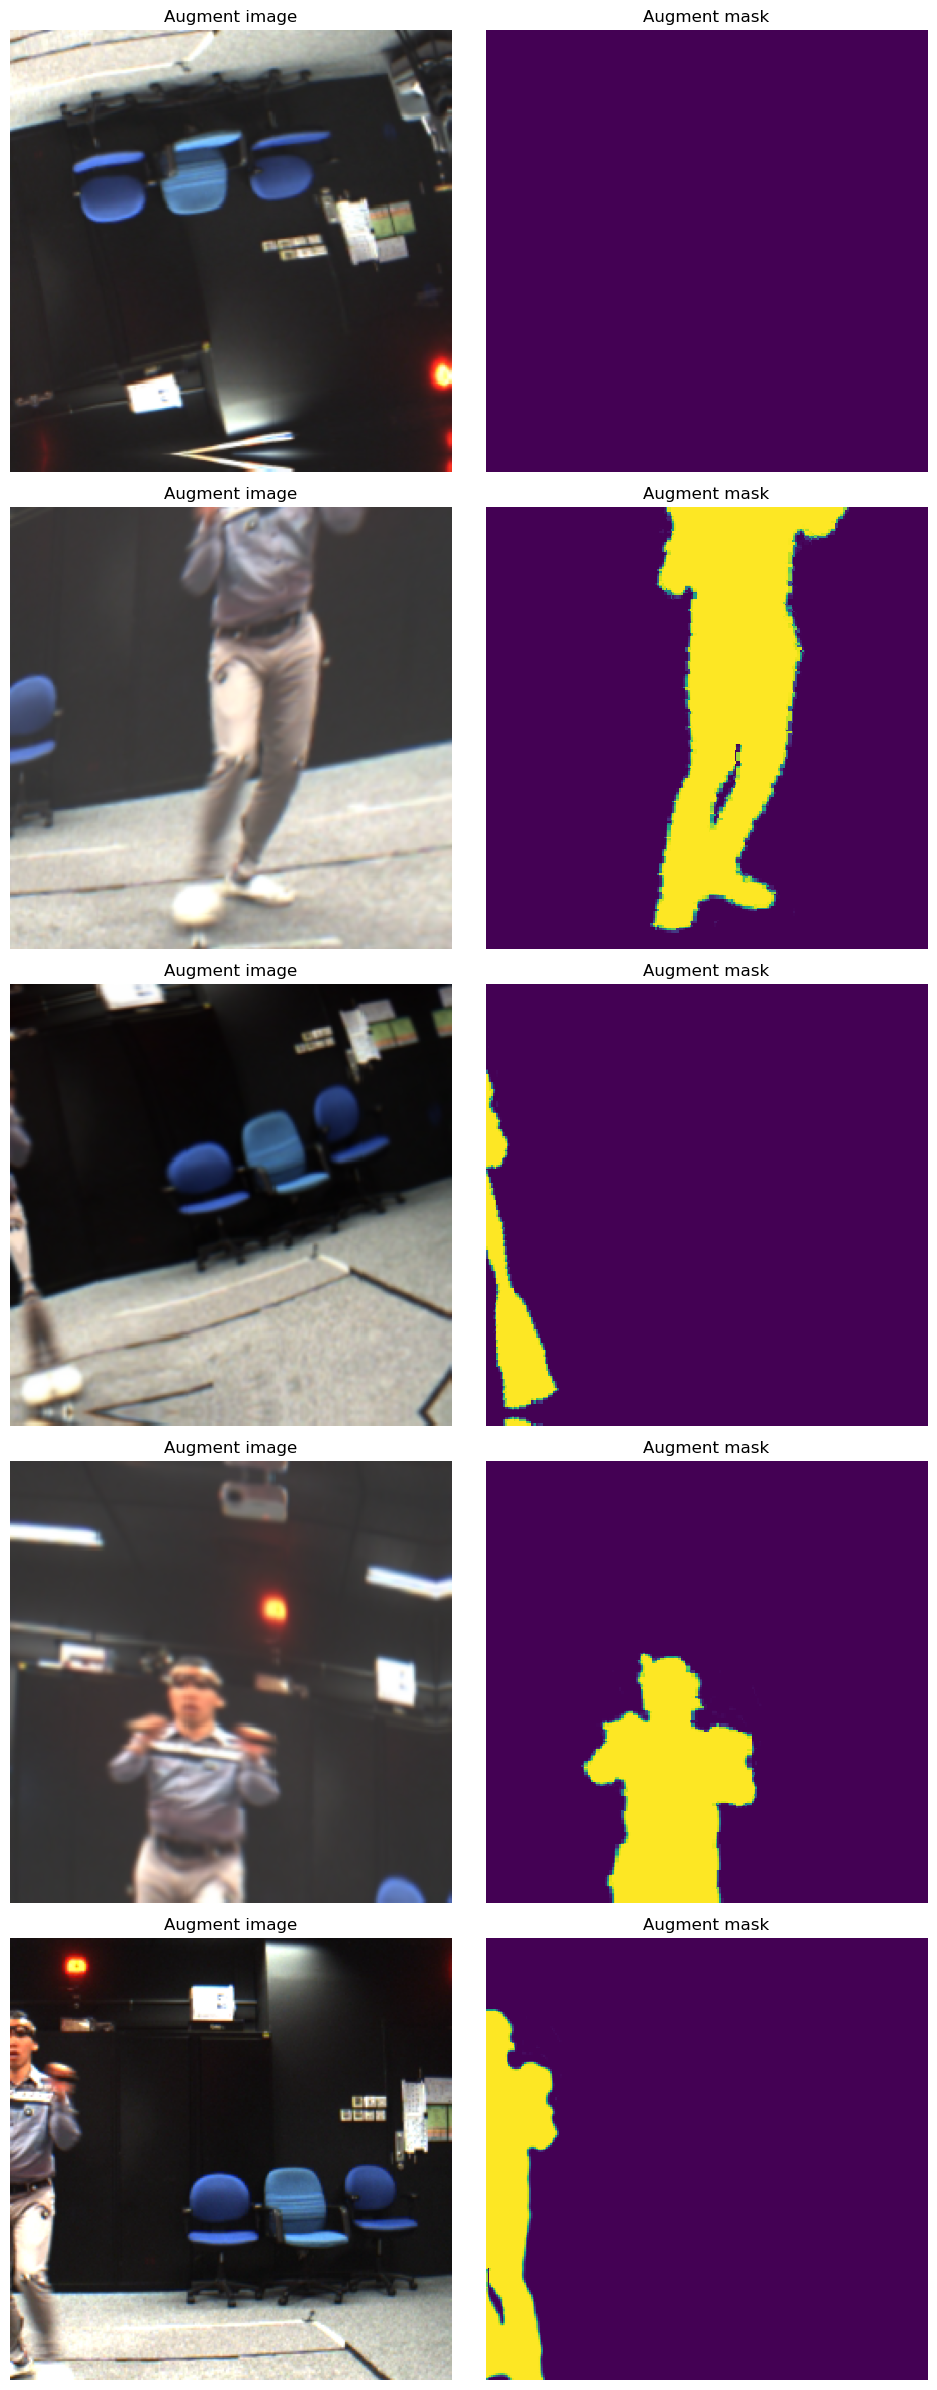

In [328]:
visualize_augmentations(ds_train, 0)

## Параметры и обучение модели

`sheduler` используется для управления темпом обучения (learning rate) во время тренировки модели. Эта функция позволяет изменять скорость обучения по экспоненциальному закону в зависимости от количества эпох или итераций.  

Цель: Постепенно уменьшать скорость обучения во время тренировки, чтобы улучшить сходимость модели и помочь ей найти более точное решение.

Параметры:  
- optimizer: Это экземпляр оптимизатора, для которого надо изменить скорость обучения. Например, torch.optim.SGD или torch.optim.Adam.
- gamma: Коэффициент уменьшения скорости обучения на каждом шаге. Если gamma равен 0.9 => скорость обучения будет уменьшаться на 10% после каждой итерации.

In [329]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    ds_train,
    shuffle=True,
    batch_size=batch_size,
    num_workers=0,
    drop_last=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = Unet(3, 32, 1)
unet_model = unet_model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001, betas=(0.9,0.999))
sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [330]:
count_params(unet_model)

5489569

In [ ]:
epochs = 10

for epoch in range(epochs):
    loss_val = 0

    for sample in (pabr := tqdm(train_loader)):
        img, mask = sample
        
        # перемещает входные изображения/маски на выбранное устройство
        img = img.to(device)
        mask = mask.to(device)
        
        # обнуление градиентов оптимизатора (что бы не накапливались)
        optimizer.zero_grad()
        
        pred = unet_model(img)
        loss = loss_fn(pred, mask)
        
        loss.backward()  # обратное распр. ошибки
        loss_item = loss.item()  # тензор потерь в числовое значение
        loss_val += loss_item
        
        # обновление пар-ов модели с использованием вычисленных градиентов
        optimizer.step()
        
    sheduler.step()  # Обновление скорости обучения
    
    print(f"{loss_val / len(train_loader)}\t lr: {sheduler.get_last_lr()}")

## Проверка работы сети

In [333]:
img = ds_train[10][0].unsqueeze(0)
pred = unet_model(img.to(device))  # (C, H, W) -> (1, C, H, W)
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

In [ ]:
img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(img_np)

In [ ]:
plt.imshow(pred)